In [3]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

This code is to show how the black-box variational inference with $\textbf{time-inhomogeneous}$ OU processes work under the observations from OU processes.

In [4]:
class OU:
    def __init__(self, t0, t1, z0, alpha, beta, sigma, dN):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
        """
        output = np.empty(len(self.pts))
        output[0] = self.z0
        interval = self.pts[1:] - self.pts[:-1]
        for t in range(1, len(self.pts)):
            
            # if the distance is too small, variance becomes 0
            dt = interval[t-1]
            
            mean = self.alpha + (output[t-1] - self.alpha) * np.exp(-1 * self.beta * dt)
            var = np.sqrt((self.sigma ** 2) * (1 - np.exp(-2 * self.beta * dt)) / (2 * self.beta))
            assert var > 0, "variance is negative, var:%.3f interval: %.3f" % (var, dt)
            output[t] = ss.norm.rvs(loc = mean, scale = var)
        return torch.from_numpy(output), interval

**Class: OU processes**

In [5]:
class tOU:
    def __init__(self, t0, t1, z0, m0, alpha, beta, sigma, r, dN):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.m0 = m0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.r = r
        self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
        """
        output = np.empty(len(self.pts))
        output[0] = self.z0
        interval = self.pts[1:] - self.pts[:-1]
        
        beta_t = self.alpha * ((( self.pts[:-1] + 1) ** self.beta) - 1 ) + self.m0 \
                - np.exp(self.r * interval) * (self.alpha * (((self.pts[1:] + 1)**self.beta) - 1) + self.m0)

        for t in range(1, len(self.pts)):
            # if the distance is too small, variance becomes 0
            mean = (output[t-1] - beta_t[t-1]) * np.exp(-1 * self.r * interval[t-1] )
            sd = np.sqrt((self.sigma / 2*self.r) * (1 - np.exp(-2 * self.r * interval[t-1])))
#             print(mean, sd)
            assert sd > 0, "standard deviation is negative, sd:%.3f interval: %.3f" % (sd, interval[t-1] )
            output[t] = ss.norm.rvs(loc = mean, scale = sd)
            
        return torch.from_numpy(output), interval

Variational inference: KL

In [22]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha, self.beta, self.sigma, self.r, self.m0 = torch.tensor([ou.alpha, ou.beta, ou.sigma, ou.r, ou.m0])
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
        def B(s, beta):
            return (s+1) ** beta
        
        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func = lambda s, z: -0.5 * (1-(r**2)) * z ** 2 + alpha * beta * (B(s, beta-1) + 1) * z \
                    -0.5 * ((r**2) - 1) * (alpha**2) * (beta**2) * B(s, 2*(beta-1)) \
                    -0.5 * (alpha * (B(s, beta) - 1) + m0 + r * alpha * beta * B(s, beta-1)) \
                    * (2 * z - alpha * (B(s, beta) - 1) - m0 - r * alpha * beta *B(s, beta - 1))
        
        func_kl = vmap(func)
        return torch.trapezoid(abs(func_kl(self.ou.pts, self.ou.trj)), x=self.ou.pts)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        z0 = self.ou.z0
        z1 = self.ou.trj[-1]
        t0 = self.ou.t0
        t1 = self.ou.t1
        
        # Obtain the rest 
        def A(s, u):
            return (r - 1) * 0.5 * (u ** 2) - u * r * alpha * (((s+1) ** beta) - 1) - r * m0 * u - alpha * beta * (s+1) * u
        
        return A(t1, z1) - A(t0, z0) - 0.5 * (r - 1) * (t1 - t0)
    
    def log_prob(self, obs):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
        """
        def log_pdf(obs, z):
            return ss.norm.logpdf(obs, loc=z, scale=.001)
            
        
        return log_pdf(obs, self.ou.trj[-1])


In [23]:
class Score:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta, m0, r):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        
        sigma = torch.tensor(self.ou.sigma)
        alpha = Variable(alpha, requires_grad = True)
        beta = Variable(beta, requires_grad = True)
        m0 = Variable(m0, requires_grad = False)
        r = Variable(r, requires_grad = True)
        
        pts = self.ou.pts
        dt = self.ou.dt
        X = self.ou.trj
 
        def compute_transition(X, dt, alpha, beta, sigma, m0, pts):
            """
            Compute the transition density of the (simulated) path
            Note that if r < 0, term1 becomes nan ( there is a constraint that r > 0)
            """
            beta_t = alpha * (((pts[:-1] + 1) ** beta) - 1) + m0 - torch.exp(r * dt) * (alpha * (((pts[1:] + 1) ** beta) - 1) + m0) 
            term1 = -0.5 * (2 * torch.log(sigma) + torch.log( 1 - torch.exp(-2 * r * dt)) - torch.log( r ))
            term2 = X[1:] - (X[:-1] - beta_t) * torch.exp( -1 * r * dt)
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * r * dt)) / r
            return torch.sum( term1 - ((term2 ** 2) / term3))
        
        NLL = compute_transition(X, dt, alpha, beta, sigma, m0, pts)

        NLL.backward()
        
        return {'beta':beta.grad.detach().clone(), 'alpha':alpha.grad.detach().clone(), "r":r.grad.detach().clone(), 'LNN':NLL.data.numpy()}


**Generate observations from Gaussian likelihood**

Noisy Observations from the SDE:

$dX_{t} = -X_{t}dt + \sigma dW_{t}$

In [24]:
true_sde = OU(t0 = 0, t1 = 6., z0 = 10, alpha = 0, beta = 1., sigma = 1., dN=1000)

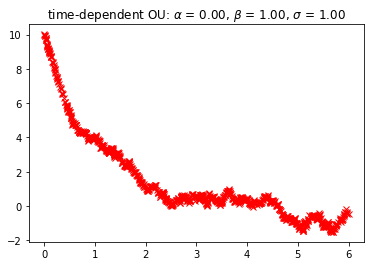

In [26]:
plt.plot(true_sde.pts, true_sde.trj, 'rx')
plt.title(r"time-dependent OU: $\alpha$ = %.2f" % true_sde.alpha + r", $\beta$ = %.2f" % true_sde.beta + r", $\sigma$ = %.2f" % true_sde.sigma)
plt.show()

In [29]:
obs = np.random.normal(loc = true_sde.trj[::100], scale = .001)
obs_time = true_sde.pts[::100]

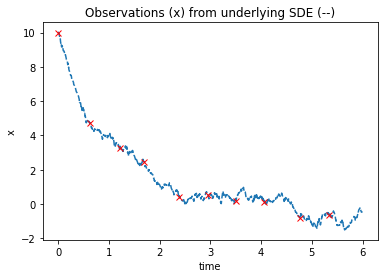

In [30]:
plt.title("Observations (x) from underlying SDE (--)")
plt.plot(true_sde.pts, true_sde.trj, '--')
plt.plot(true_sde.pts[::100], obs, 'rx')
plt.xlabel("time")
plt.ylabel("x")
plt.show()

**Variational inference: a piece-wise approximation**

1. one-time variational inference from t=0 to t=1

In [31]:
import tqdm as tq

In [41]:
beta_ = 1.
alpha_ = 0.
r_ = 1.
m0 = obs[0]

N = 50
N_e = 50
learning_rate = 0.0000001
lr = learning_rate

trace_pars = []
trace_elbo = []
for k in tq.tqdm(range(300)):
    beta_grad = 0.
    alpha_grad = 0.
    r_grad = 0.

    for i in range(N):
        vi = tOU(t0 = obs_time[0], t1 = obs_time[1], z0 = obs[0], m0 = m0, alpha = alpha_, beta = beta_, sigma = 1, r = r_, dN = 30)
        elbo = ELBO(vi)
        score = Score(vi)
        
        scores = score.compute_score(torch.tensor(alpha_, dtype=torch.float64), torch.tensor(beta_, dtype=torch.float64)\
                                    , torch.tensor(m0, dtype=torch.float64), torch.tensor(r_, dtype=torch.float64))
        f_of_X = -1 * (elbo.log_prob(obs[1]) + elbo.KL_ito() + elbo.KL_rest())
        beta_grad += f_of_X * scores['beta']
        alpha_grad += f_of_X * scores['alpha']
        r_grad += f_of_X * scores['r']
        
    beta_ -= learning_rate * (beta_grad/N).numpy()
    alpha_ -= learning_rate * (alpha_grad/N).numpy()
    r__ = r_ + learning_rate * (r_grad/N).numpy()
    
    # It is to ensure r should be strictly positive (i.e. projected gradient method)
    while r__ < 0:
        r__ = r_ + lr * (r_grad/N).numpy()
        lr *= 0.5
    r_ = r__

    
    elbo_estimate = 0
    for j in range(N_e):
        vi_ = tOU(t0 = obs_time[0], t1=obs_time[1], z0 = obs[0], m0 = m0, alpha = alpha_, beta = beta_, sigma = 1, r = r_, dN = 30)
        elbo_ = ELBO(vi_)
        elbo_estimate += -1 * (elbo_.log_prob(obs[1]) + elbo_.KL_ito() + elbo_.KL_rest())
    
    elbo_estimate *= 1/N_e
    
    if k % 100 == 0:
        print("beta = ", beta_, "alpha = ", alpha_, "r = ", r_, 'ELBO = ', elbo_estimate)
    
    trace_pars.append((beta_, alpha_, r_))
    trace_elbo.append(elbo_estimate)
# score.compute_score()

  0%|▏                                          | 1/300 [00:00<01:47,  2.79it/s]

beta =  1.0 alpha =  -0.2391065193020674 r =  1.1020055605339436 ELBO =  tensor(13659433.8887, dtype=torch.float64)


 34%|█████████████▊                           | 101/300 [00:34<01:08,  2.91it/s]

beta =  2.5270421500333686 alpha =  -2.0246558703690205 r =  0.7187947609131771 ELBO =  tensor(139622.4062, dtype=torch.float64)


 67%|███████████████████████████▍             | 201/300 [01:08<00:34,  2.91it/s]

beta =  2.5756386948118166 alpha =  -2.0862337265788433 r =  0.6537940277604096 ELBO =  tensor(67760.5332, dtype=torch.float64)


100%|█████████████████████████████████████████| 300/300 [01:42<00:00,  2.91it/s]


**Posterior mean**

In [42]:
post_mean = lambda x: alpha_ * (((x + 1) ** beta_) - 1) + m0

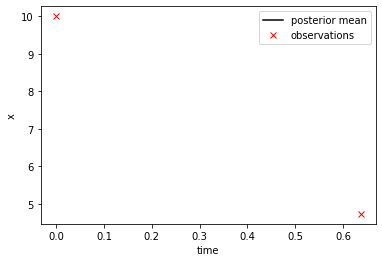

In [88]:
# plt.plot(true_sde.pts[:100], true_mean(true_sde.pts)[:100], color='r', alpha=0.3, linestyle='dashed', label="true mean")
plt.plot(true_sde.pts[:100], post_mean(true_sde.pts)[:100], color='black', label="posterior mean")
plt.plot(true_sde.pts[::100][:2], obs[:2], 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

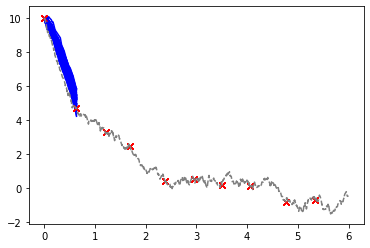

In [50]:
for i in range(50):
    posterior = tOU(t0 = obs_time[0], t1 = obs_time[1], z0 = obs[0], m0 = obs[0], alpha = alpha_, beta = beta_, sigma = 1, r = r_, dN = 30)
    plt.plot(posterior.pts, posterior.trj, 'b')
    plt.plot(obs_time, obs, 'rx')
plt.plot(true_sde.pts,true_sde.trj, 'grey', linestyle='dashed')

**Trace plot: gradient**

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
names = [r'$\beta$', r'$\alpha$', 'r']
for i, ax in enumerate(ax.ravel()):
    par = [item[i] for item in trace_pars]
    ax.plot(np.arange(len(par)), par)
    ax.set_title(names[i])
    ax.set_xlabel('iterations')
    ax.set_ylabel(names[i])
# plt.title("Trace plot: beta")
# plt.plot(np.arange(len(betas)), betas)
# plt.xlabel("iteration")
# plt.ylabel(r"$\beta$")
# plt.show()

**Trace plot: ELBO**

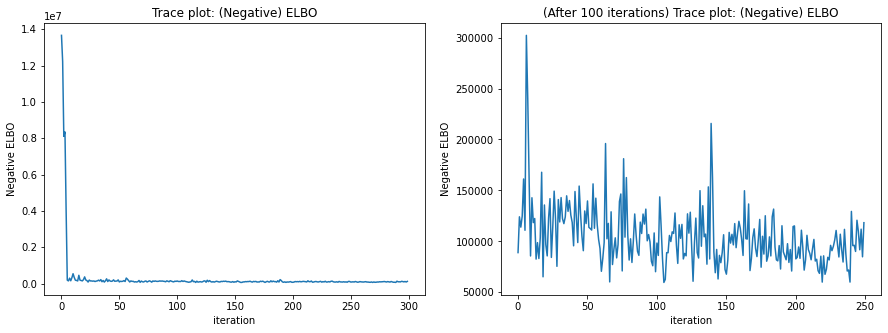

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, ax in enumerate(ax.ravel()):
    ax.set_title("Trace plot: (Negative) ELBO")
    if i == 0:
        ax.plot(np.arange(len(trace_elbo)), trace_elbo)
    else:
        ax.plot(np.arange(len(trace_elbo[50:])), trace_elbo[50:])
        ax.set_title("(After 100 iterations) Trace plot: (Negative) ELBO")
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO")
plt.show()

**Posterior moment based on the average of last 30 iterations of beta**

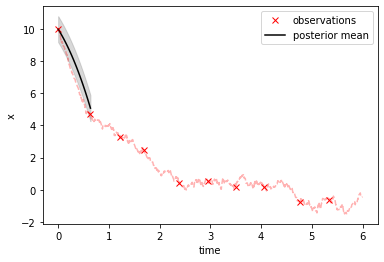

In [74]:
postmean = post_mean(true_sde.pts[:100])

plt.plot(obs_time, obs, 'rx', label="observations")
plt.plot(true_sde.pts[:100], postmean, color='black', label="posterior mean")
plt.plot(true_sde.pts,true_sde.trj, 'red', linestyle='dashed', alpha= 0.3)
plt.fill_between(true_sde.pts[:100], postmean - 0.5/r_, postmean + 0.5/r_, color='grey', alpha=0.3)
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

In [89]:
beta_ = 1.
alpha_ = 0.
r_ = 1.
m0 = obs[3]

N = 50
N_e = 50
learning_rate = 0.0000001
lr = learning_rate

trace_pars = []
trace_elbo = []
for k in tq.tqdm(range(300)):
    beta_grad = 0.
    alpha_grad = 0.
    r_grad = 0.

    for i in range(N):
        vi = tOU(t0 = obs_time[3], t1 = obs_time[4], z0 = obs[3], m0 = m0, alpha = alpha_, beta = beta_, sigma = 1, r = r_, dN = 30)
        elbo = ELBO(vi)
        score = Score(vi)
        
        scores = score.compute_score(torch.tensor(alpha_, dtype=torch.float64), torch.tensor(beta_, dtype=torch.float64)\
                                    , torch.tensor(m0, dtype=torch.float64), torch.tensor(r_, dtype=torch.float64))
        f_of_X = -1 * (elbo.log_prob(obs[4]) + elbo.KL_ito() + elbo.KL_rest())
        beta_grad += f_of_X * scores['beta']
        alpha_grad += f_of_X * scores['alpha']
        r_grad += f_of_X * scores['r']
        
    beta_ -= learning_rate * (beta_grad/N).numpy()
    alpha_ -= learning_rate * (alpha_grad/N).numpy()
    r__ = r_ + learning_rate * (r_grad/N).numpy()
    
    # It is to ensure r should be strictly positive (i.e. projected gradient method)
    while r__ < 0:
        r__ = r_ + lr * (r_grad/N).numpy()
        lr *= 0.5
    r_ = r__

    
    elbo_estimate = 0
    for j in range(N_e):
        vi_ = tOU(t0 = obs_time[3], t1=obs_time[4], z0 = obs[3], m0 = m0, alpha = alpha_, beta = beta_, sigma = 1, r = r_, dN = 30)
        elbo_ = ELBO(vi_)
        elbo_estimate += -1 * (elbo_.log_prob(obs[4]) + elbo_.KL_ito() + elbo_.KL_rest())
    
    elbo_estimate *= 1/N_e
    
    if k % 100 == 0:
        print("beta = ", beta_, "alpha = ", alpha_, "r = ", r_, 'ELBO = ', elbo_estimate)
    
    trace_pars.append((beta_, alpha_, r_))
    trace_elbo.append(elbo_estimate)
# score.compute_score()

  0%|▏                                          | 1/300 [00:00<01:47,  2.79it/s]

beta =  1.0 alpha =  -0.5667520929625522 r =  0.9493234014670667 ELBO =  tensor(901637.7292, dtype=torch.float64)


 34%|█████████████▊                           | 101/300 [00:35<01:08,  2.91it/s]

beta =  1.334936262770544 alpha =  -0.8909922169783216 r =  0.6565953244269787 ELBO =  tensor(121093.5992, dtype=torch.float64)


 67%|███████████████████████████▍             | 201/300 [01:09<00:34,  2.88it/s]

beta =  1.3385505734189158 alpha =  -0.9003530116234976 r =  0.6292867644532301 ELBO =  tensor(81255.0550, dtype=torch.float64)


100%|█████████████████████████████████████████| 300/300 [01:43<00:00,  2.89it/s]


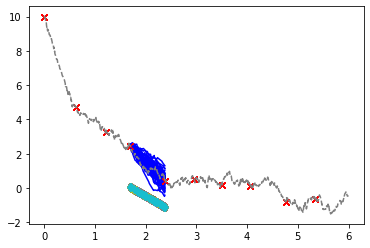

In [127]:
for i in range(50):
    posterior = tOU(t0 = obs_time[3], t1 = obs_time[4], z0 = obs[3], m0 = obs[3], alpha = alpha_, beta = beta_, sigma = 1, r = r_, dN = 30)
    plt.plot(posterior.pts, posterior.trj, 'b')
    plt.plot(posterior.pts, func(posterior.pts), 'd')
    plt.plot(obs_time, obs, 'rx')
plt.plot(true_sde.pts,true_sde.trj, 'grey', linestyle='dashed')

In [95]:
post_mean = lambda x: alpha_ * (((x + 1) ** beta_) - 1) + m0

In [112]:
alpha_ * ((true_sde.pts[300:400] + 1) ** beta_ - 1) + m0

tensor([ 0.0448,  0.0303,  0.0240,  0.0080, -0.0101, -0.0166, -0.0264, -0.0311,
        -0.0436, -0.0824, -0.0860, -0.0891, -0.0960, -0.1058, -0.1069, -0.1185,
        -0.1421, -0.1495, -0.1634, -0.1731, -0.1809, -0.2077, -0.2283, -0.2418,
        -0.2420, -0.2437, -0.2527, -0.2643, -0.2732, -0.2794, -0.2835, -0.2884,
        -0.2924, -0.3038, -0.3056, -0.3312, -0.3469, -0.3504, -0.3677, -0.3800,
        -0.3875, -0.4113, -0.4171, -0.4253, -0.4622, -0.4777, -0.4865, -0.4969,
        -0.4985, -0.5009, -0.5068, -0.5206, -0.5265, -0.5368, -0.5415, -0.5614,
        -0.5678, -0.6114, -0.6131, -0.6324, -0.6440, -0.6459, -0.6539, -0.6934,
        -0.6948, -0.7032, -0.7349, -0.7471, -0.7593, -0.7706, -0.7848, -0.7849,
        -0.7868, -0.8123, -0.8501, -0.8862, -0.8878, -0.8879, -0.8893, -0.8928,
        -0.8934, -0.9334, -0.9355, -0.9399, -0.9819, -0.9867, -1.0062, -1.0093,
        -1.0229, -1.0307, -1.0327, -1.0384, -1.0385, -1.0403, -1.0528, -1.0600,
        -1.0619, -1.0824, -1.0828, -1.09

In [155]:
toy_sde = tOU(3, 100, m0, m0, alpha_, beta_, 1., r_, dN = 30)
toy_sde_trj, toy_sde_dt = toy_sde.simulate()

In [156]:
m0

2.4783213092734035

In [157]:
func = lambda x: alpha_ * (((x + 1) ** beta_) - 1) + m0

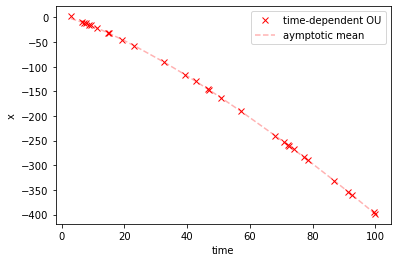

In [158]:
plt.plot(toy_sde.pts, toy_sde_trj, 'rx', label = 'time-dependent OU')
plt.plot(toy_sde.pts, func(toy_sde.pts), linestyle='dashed', color='red', alpha=0.3, label='aymptotic mean')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

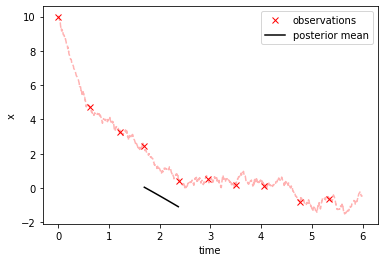

In [101]:
postmean = post_mean(true_sde.pts[300:400])

plt.plot(obs_time, obs, 'rx', label="observations")
plt.plot(true_sde.pts[300:400], postmean, color='black', label="posterior mean")
plt.plot(true_sde.pts,true_sde.trj, 'red', linestyle='dashed', alpha= 0.3)
plt.fill_between(true_sde.pts[300:400], postmean - 0.5/r_, postmean + 0.5/r_, color='grey', alpha=0.3)
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

2. Complete piece-wise optimization from t=0 to t=10

We use the posterior mean of the previous step as our initial value for next vi

In [77]:
N = 50
N_e = 50
learning_rate = 0.0000001
lr = learning_rate
z0 = obs[0]
IT = 100

elbo_traces = np.empty((9, IT))
pars_traces = np.empty((3, 9, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    beta_ = np.random.uniform(1, 3)
    alpha_ = 0.
    r_ = np.random.uniform(1, 2)
  
    for i in range(IT):
        beta_grad = 0.
        alpha_grad = 0.
        r_grad = 0.
        
        for k in range(N):
            vi = tOU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0, m0 = z0, alpha = alpha_ , beta = beta_ , sigma = 1., r = r_, dN=30)
            elbo = ELBO(vi)
            score = Score(vi)

            scores = score.compute_score(torch.tensor(alpha_, dtype=torch.float64), torch.tensor(beta_, dtype=torch.float64)\
                            , torch.tensor(z0, dtype=torch.float64), torch.tensor(r_, dtype=torch.float64))

            f_of_X = -1 * (elbo.log_prob(obs[t+1]) + elbo.KL_ito() + elbo.KL_rest())
            
            beta_grad += f_of_X * scores['beta']
            alpha_grad += f_of_X * scores['alpha']
            r_grad += f_of_X * scores['r']
            
        beta_ -= learning_rate * (beta_grad/N).numpy()
        alpha_ -= learning_rate * (alpha_grad/N).numpy()
        r__ = r_ + learning_rate * (r_grad/N).numpy()
    
        # It is to ensure r should be strictly positive (i.e. projected gradient method)
        while r__ < 0:
            r__ = r_ + lr * (r_grad/N).numpy()
            lr *= 0.5
        r_ = r__

        
        pars_traces[0, t, i] = alpha_
        pars_traces[1, t, i] = beta_
        pars_traces[2, t, i] = r_
        
        elbo_estimate = 0
        for j in range(N_e):
            vi_ = tOU(t0 = obs_time[t], t1=obs_time[t+1], z0 = z0, m0 = z0, alpha = alpha_, beta = beta_ , sigma = 1., r = r_, dN=30)
            elbo_ = ELBO(vi_)
            elbo_estimate += -1 * (elbo_.log_prob(obs[t+1]) + elbo_.KL_ito() + elbo_.KL_rest())
    
        elbo_estimate *= 1/N_e
        if i % 10 == 0:
            print("alpha = ", alpha_, "beta = ", beta_, "r = ", r_, "elbo = ", elbo_estimate)
        elbo_traces[t, i] = elbo_estimate

    z0 +=  alpha_ * (((obs_time[t+1] + 1) ** np.mean(pars_traces[1, t, -30:])) - 1)
    
# score.compute_score()

  0%|                                                     | 0/9 [00:00<?, ?it/s]

alpha =  -0.14830856191630004 beta =  1.8707776637109255 r =  1.0318707195345207 elbo =  tensor(12978926.6600, dtype=torch.float64)
alpha =  -2.033737354429235 beta =  2.615122689741801 r =  1.0402894476430484 elbo =  tensor(167427.3472, dtype=torch.float64)
alpha =  -1.9850220601047999 beta =  2.5214106729358248 r =  0.9594881009907735 elbo =  tensor(269686.0085, dtype=torch.float64)
alpha =  -2.0454572455167983 beta =  2.622749303979721 r =  0.9060899645886381 elbo =  tensor(153180.5101, dtype=torch.float64)
alpha =  -2.0242249810005184 beta =  2.594261253074332 r =  0.8546132045720274 elbo =  tensor(101844.0156, dtype=torch.float64)
alpha =  -2.0851386052834853 beta =  2.662625167865263 r =  0.8166267324157964 elbo =  tensor(149890.5720, dtype=torch.float64)
alpha =  -2.0341697382977797 beta =  2.597270802976694 r =  0.7820132134478902 elbo =  tensor(125194.6610, dtype=torch.float64)
alpha =  -2.044429664306275 beta =  2.606334864963803 r =  0.7533790247574605 elbo =  tensor(146409.

 11%|█████                                        | 1/9 [00:34<04:35, 34.43s/it]/var/folders/2c/_gzbr1y51ws47zfknhxm868h0000gr/T/ipykernel_15408/1421877202.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  , torch.tensor(z0, dtype=torch.float64), torch.tensor(r_, dtype=torch.float64))


alpha =  -1.6349495891961499 beta =  2.1904842317564435 r =  1.347412363029971 elbo =  tensor(11628857.7392, dtype=torch.float64)
alpha =  2.603312910583715 beta =  -5.277174530741404 r =  1.0542060142472236 elbo =  tensor(178727.1341, dtype=torch.float64)
alpha =  2.6898394784271042 beta =  -5.272303807750896 r =  0.8539234135816262 elbo =  tensor(231462.9357, dtype=torch.float64)
alpha =  2.7910193475281737 beta =  -5.263637884130478 r =  0.5937991166029546 elbo =  tensor(302490.2936, dtype=torch.float64)
alpha =  2.8426220597896177 beta =  -5.256445726378765 r =  0.4537152786553118 elbo =  tensor(296712.8652, dtype=torch.float64)
alpha =  2.871242738628923 beta =  -5.2510949069084525 r =  0.39236613416752636 elbo =  tensor(335639.0976, dtype=torch.float64)
alpha =  2.8963405682794137 beta =  -5.245605102038009 r =  0.34737724201875175 elbo =  tensor(372541.7594, dtype=torch.float64)
alpha =  2.9193985241479288 beta =  -5.240068047796261 r =  0.31120463178090324 elbo =  tensor(400237

 22%|██████████                                   | 2/9 [01:08<04:01, 34.49s/it]

alpha =  0.4911847289639202 beta =  2.5048563849758283 r =  1.036773305628758 elbo =  tensor(4427455.3555, dtype=torch.float64)
alpha =  -2.0824090770856465 beta =  -1.2486235352457744 r =  1.5328251484177218 elbo =  tensor(304372.2669, dtype=torch.float64)
alpha =  -1.974985871634256 beta =  -1.1695368110496756 r =  1.3279300948248456 elbo =  tensor(264046.5807, dtype=torch.float64)
alpha =  -1.963208090537235 beta =  -1.1605731812356745 r =  1.1696697668447997 elbo =  tensor(186298.7697, dtype=torch.float64)
alpha =  -1.9426137601066296 beta =  -1.1452641981856007 r =  1.0787548021561144 elbo =  tensor(215940.0988, dtype=torch.float64)
alpha =  -1.929346934178031 beta =  -1.1351686288042708 r =  1.0182925202834228 elbo =  tensor(168138.0369, dtype=torch.float64)
alpha =  -1.9482975138549172 beta =  -1.1496223909774448 r =  0.9420871409384342 elbo =  tensor(156726.7778, dtype=torch.float64)
alpha =  -1.9688608100349034 beta =  -1.1649807916011827 r =  0.8716944794923298 elbo =  tensor

 33%|███████████████                              | 3/9 [01:43<03:26, 34.46s/it]

alpha =  -5.941073857901475 beta =  2.5012981628514948 r =  1.2575479606975775 elbo =  tensor(3.9036e+09, dtype=torch.float64)


 33%|███████████████                              | 3/9 [01:44<03:28, 34.75s/it]


AssertionError: standard deviation is negative, sd:nan interval: 0.031

Trace plot: ELBO

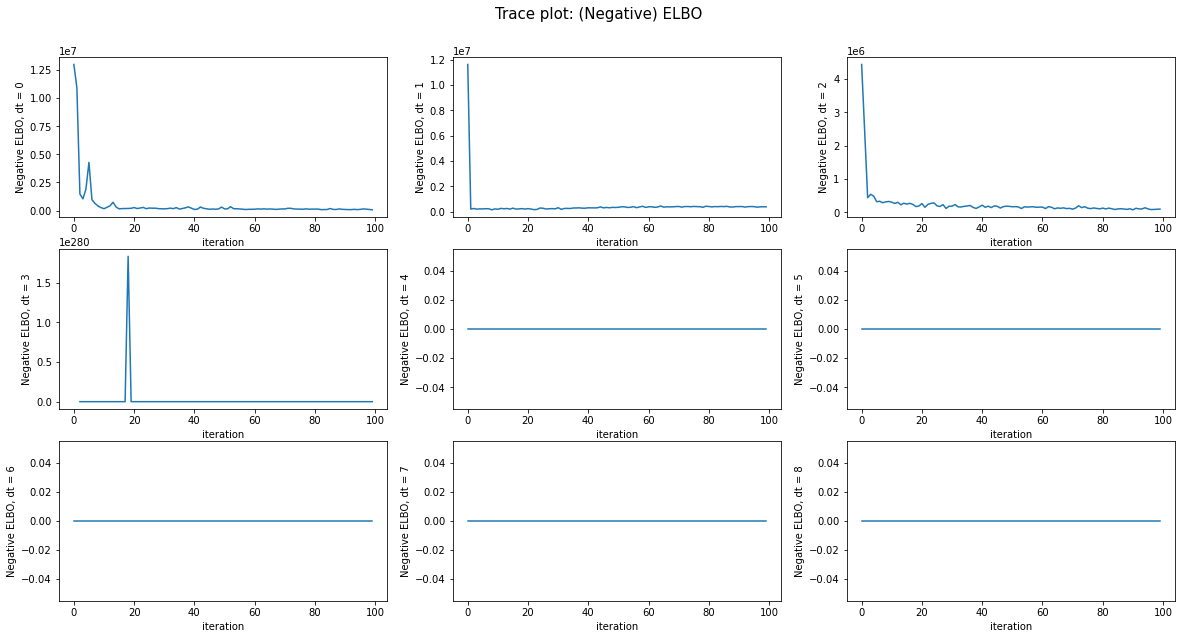

In [78]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(elbo_traces[t, :IT])), elbo_traces[t, :IT])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

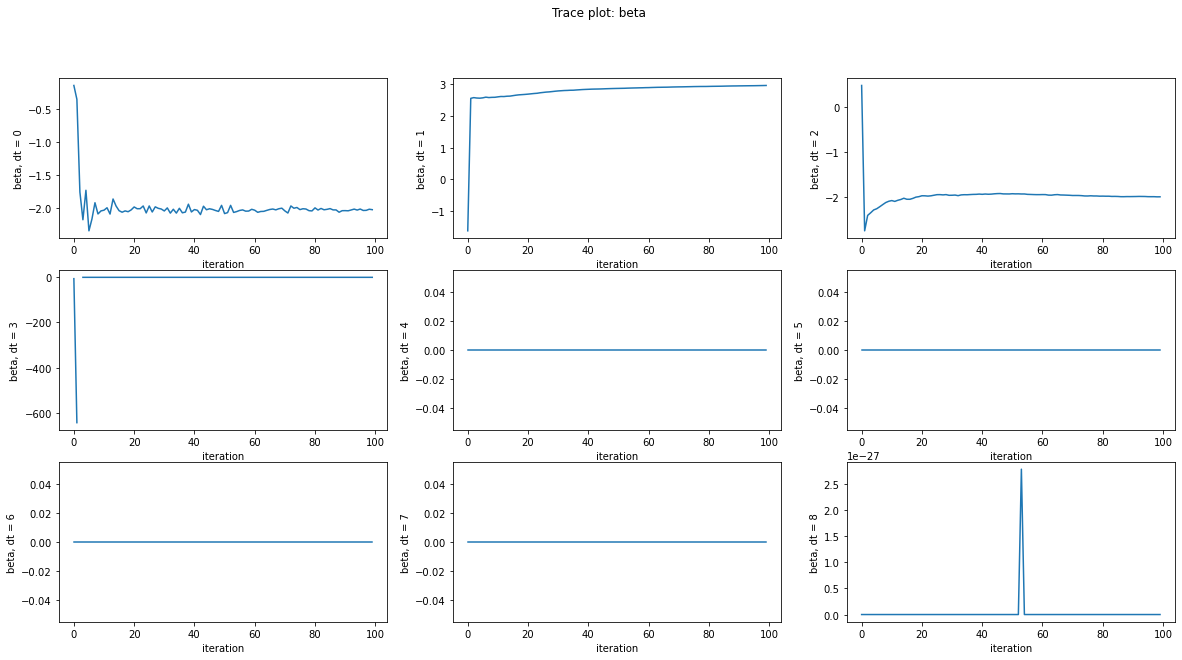

In [79]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(pars_traces[0, t, :IT])), pars_traces[0, t, :IT])
    ax.set_xlabel("iteration")
    ax.set_ylabel("beta, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: beta")
plt.show()

In [80]:
def g_posterior_moment(init, alpha, vi_beta, t0, t1):
    """
        Obtain credible interval
            posterior mean and variance are computed based on the theory (using fitted variational parameter at each interval)
    """
    sigma = 1.
    pts = np.linspace(t0,t1,900)
    dt = pts[1:] - pts[:-1]
    
    mean = [init]
    var = list(map(lambda t: np.sqrt((sigma ** 2 / (2*vi_beta[0])) * (1 - np.exp(-2 * vi_beta[0] * t))), dt[:100]))
    
    k = 0
    for j in range(dt.shape[0]):
        if j % 100 == 0:
            beta = vi_beta[k]
            k += 1
        mean.append(alpha + (mean[j] - alpha)*np.exp(-1 * beta * dt[j]))
        if (j % 100 == 0) and (j > 0):
            func = lambda t: np.sqrt((sigma ** 2 / (2*beta)) * (1 - np.exp(-2 * beta * t)))
            var += list(map(func, dt[j-100:j]))
    return np.array(mean), np.array(var)

In [81]:
pmean, pvar = g_posterior_moment(obs[0], 0, vi_beta, 0, 6)

NameError: name 'vi_beta' is not defined

NameError: name 'pmean' is not defined

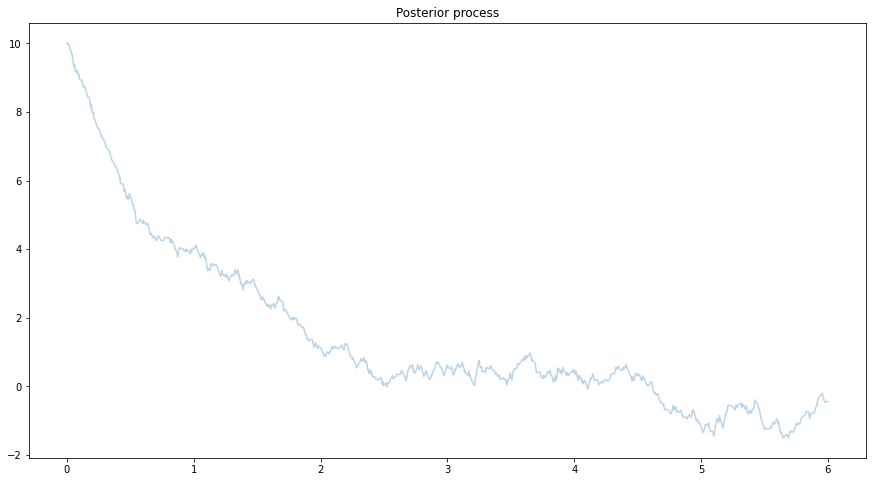

In [82]:
plt.figure(figsize=(15,8))
plt.title("Posterior process")
plt.plot(true_sde.pts, true_sde.trj, alpha=0.3, label='underlying SDE')
plt.plot(true_sde.pts[:900], pmean, 'black', label='posterior mean')
plt.fill_between(true_sde.pts[:900], pmean - pvar, pmean + pvar, alpha=0.5, color='grey')
plt.plot(obs_time, obs, 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()